# Lutte contre la criminalité organisée Algorithme de détection de faux billets

*Etude data - Projet 6 - Nalron (décembre 2019) / ENSAE-ENSAI Formation Continue*

*Data source* [Office central pour la répression du faux monnayage](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)

---

## Propos liminaire 

<span style="font-weight: bold; text-decoration: underline">Définition Wikipedia :</span>
Le faux-monnayage est la contrefaçon de monnaie, et, sur le plan légal et judiciaire, l’infraction consistant à fabriquer, à détenir ou à utiliser de la fausse monnaie. [[en savoir +]](https://fr.wikipedia.org/wiki/Faux-monnayage)


<span style="font-weight: bold; text-decoration: underline">L’office central pour la répression du faux monnayage :</span>
L'OCRFM a été créé le 11 septembre 1929, en application de la Convention de Genève. Il centralise les renseignements pouvant faciliter les recherches, la prévention et la répression du faux monnayage. [[en savoir +]](https://www.police-nationale.interieur.gouv.fr/Organisation/Direction-Centrale-de-la-Police-Judiciaire/Lutte-contre-la-criminalite-organisee/Office-central-pour-la-repression-du-faux-monnayage)

### Scénario :

Société de consulting informatique *(préférant garder l'anonymat)*, un nouveau contrat au [Ministère de l'Intérieur](https://www.interieur.gouv.fr/) a été remporté. Cette nouvelle mission intervient dans le cadre de la lutte contre la criminalité organisée, à [l'Office central pour la répression du faux monnayage](https://www.police-nationale.interieur.gouv.fr/Organisation/Direction-Centrale-de-la-Police-Judiciaire/Lutte-contre-la-criminalite-organisee/Office-central-pour-la-repression-du-faux-monnayage). La mission est d'intérêt public, élaborer un algorithme de détection de faux billets. Un seul mot d'ordre : **Traquer la moindre fraude!**

### Les données de la Police Judiciaire :
La PJ a transmis un [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv) contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

- la longueur du billet (en mm);
- la hauteur du billet (mesurée sur le côté gauche, en mm);
- la hauteur du billet (mesurée sur le côté droit, en mm);
- la marge entre le bord supérieur du billet et l'image de celui-ci (en mm);
- la marge entre le bord inférieur du billet et l'image de celui-ci (en mm);
- la diagonale du billet (en mm).

---

In [1]:
#Import des principales librairies Python
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Paramètres de style
plt.style.use('ggplot') 
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 16, 'axes.titlesize': 24})

In [4]:
#Principales versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))

Jupyter Notebook : 0.25.3
Pandas : 0.25.3
Numpy : 1.17.4
Matplotlib : 3.1.0
Seaborn : 0.9.0


## Description du jeu de données 

La PJ a transmis un fichier csv contenant les caractéristiques enoncées ci-dessus. Une première analyse est nécessaire pour pouvoir se faire une idée plus précise des données que nous avons à disposition.

A l'exception de la variable booléenne *'is_genuine'*, les 6 autres variables sont <span style="text-decoration: underline">quantitatives continues</span>. Voyons comment aborder ces variables.

In [5]:
#Chargement du jeu de données avec aperçu rapide des 5 premières lignes
data = pd.read_csv('p6_data/notes.csv')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [6]:
#Représentation des effectifs par type de billet vrai/faux(méthode utilisée .value_counts())
effectif = data['is_genuine'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data) #len(data) renvoie la taille de l'échantillon
tab

,is_genuine,n,f
0,True,100,0.588235
1,False,70,0.411765


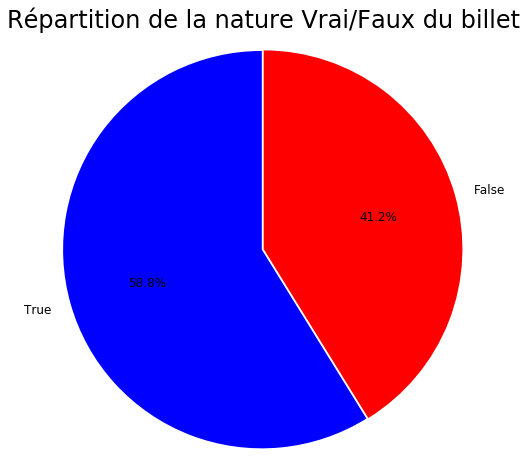

In [7]:
#Création d'un Pie Chart pour représenter la part de chaque type de billet
labels = 'True', 'False'
sizes = tab['f']
explode = (0.01, 0)

fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, explode=explode, labels=labels, colors=['blue','red'], 
        autopct='%1.1f%%', shadow=False, startangle=90)

ax.axis('equal') 
plt.title('Répartition de la nature Vrai/Faux du billet')

plt.savefig("p6_graphic/piechart.png")
plt.show()

In [8]:
#Taille du jeu de données
data.shape

(170, 7)

*Le jeu de données contient 170 observations, 7 variables, les 6 caractéristiques listées en préambule, ainsi qu'une colonne de type booléenne permettant d'authentifier le billet (vrai ou faux billet de banque).*

In [9]:
#Valeurs descriptives des variables quantitatives
data.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,170.0,171.940588,0.305768,171.04,171.7300,171.945,172.1375,173.01
height_left,170.0,104.066353,0.298185,103.23,103.8425,104.055,104.2875,104.86
height_right,170.0,103.928118,0.330980,103.14,103.6900,103.950,104.1700,104.95
margin_low,170.0,4.612118,0.702103,3.54,4.0500,4.450,5.1275,6.28
margin_up,170.0,3.170412,0.236361,2.27,3.0125,3.170,3.3300,3.68
length,170.0,112.570412,0.924448,109.97,111.8550,112.845,113.2875,113.98


*Ce tableau permet d'avoir une première idée des données que nous avons. Synthétique et très rapide à établir, c'est un point d'entré pertinent avant de pouvoir mieux connaître les variables et individus de l'échantillon.*

In [10]:
#Recherche de valeur(s) manquante(s)
data.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

*Le jeu de données n'a pas de valeur manquante, la fonction .isna().any() ne renvoie aucun "True".*

In [11]:
#Recherche de doublons 
data.duplicated().sum()

0

*Le jeu de données n'a pas de doublon, la fonction .duplicated().sum() ne renvoie aucune valeur.*

In [12]:
#Recherche de valeur(s) négative(s) 
display(data[data<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

*Le jeu de données n'a aucune valeur négative.*

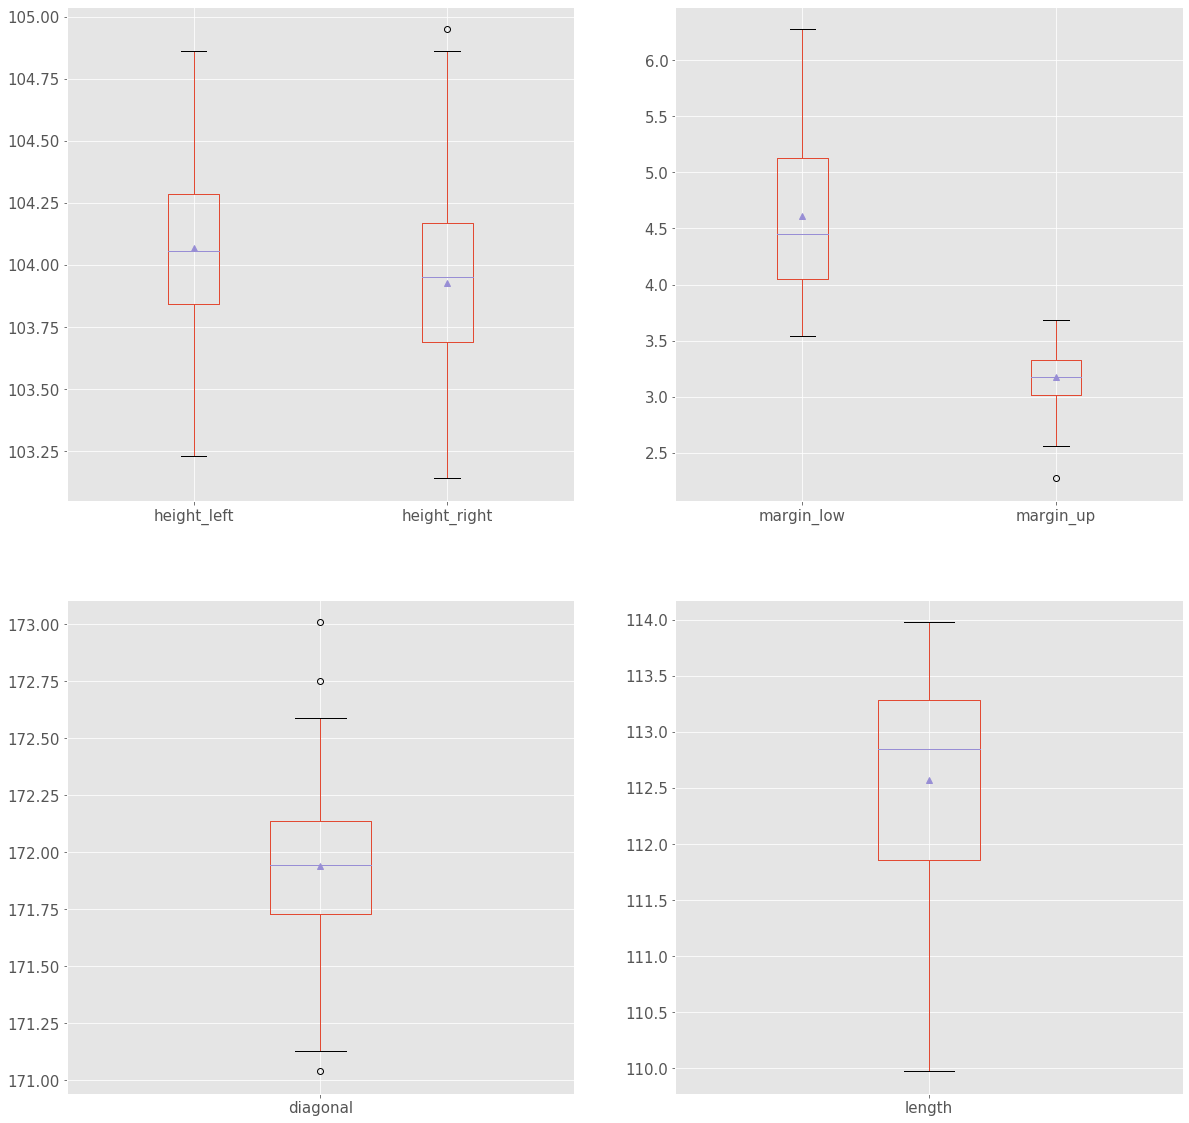

In [13]:
#Approche / identification visuelle par Boxplot de la distribution des variables et des éventuels outliers
plt.figure(figsize=(20, 20))
plt.title('Boxplot billet sans distinction vrai/faux')

plt.subplot(221)
data.iloc[:, 2:4].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(222)
data.iloc[:, 4:6].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
data.iloc[:, 1:2].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
data.iloc[:, -1:].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig("p6_graphic/boxplot_1.png")
plt.show()

*A partir des Boxplots ci-dessus on peut identifier quelques outliers, mais sans prendre en compte la nature du billet (Vrai/Faux).\
<strong>Essayons l'approche Boxplot par variable selon la nature du billet.</strong>*

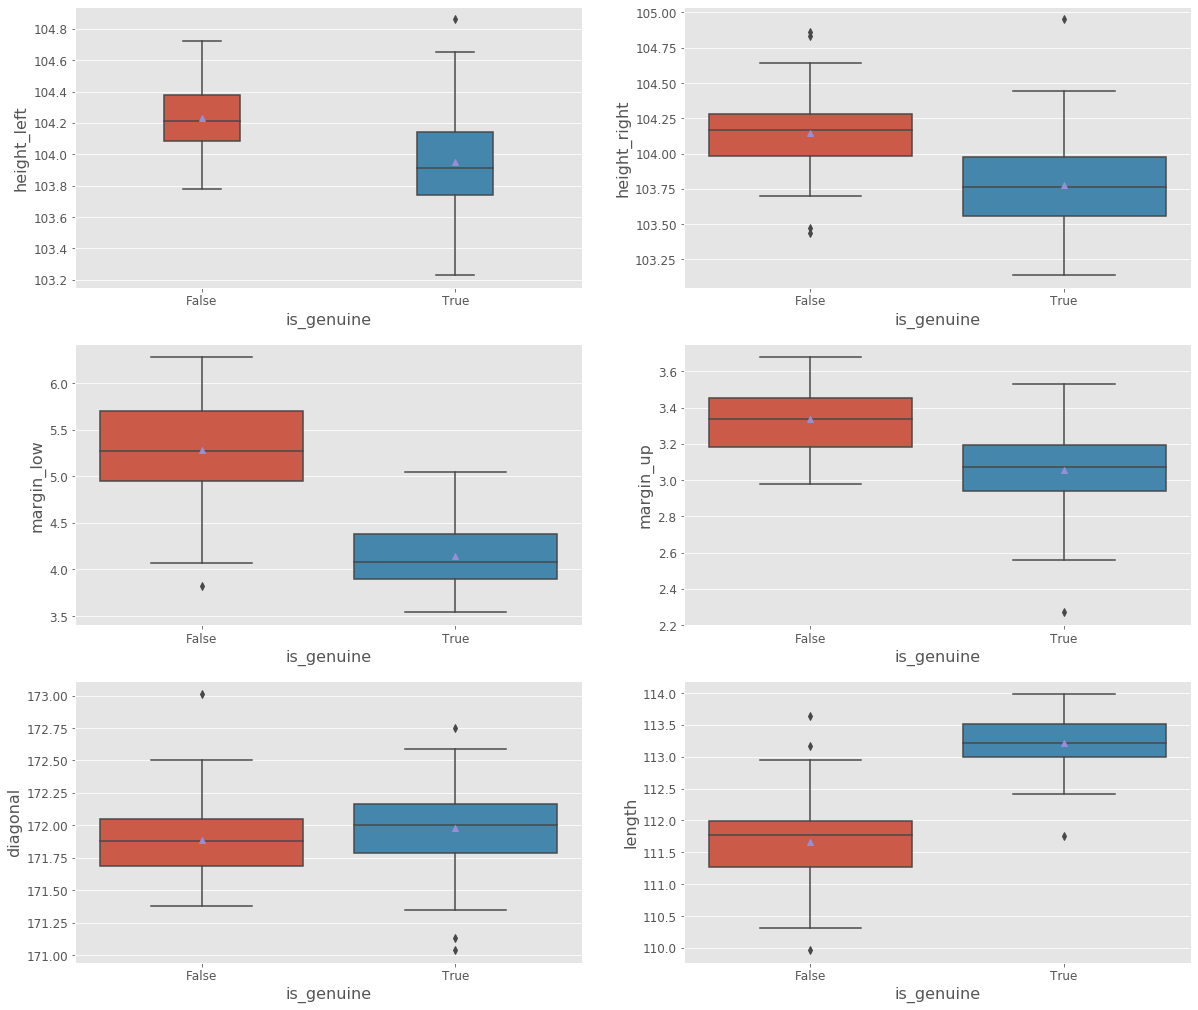

In [14]:
plt.figure(figsize=(20, 30))

plt.subplot(521)
sns.boxplot(x='is_genuine', y='height_left', width=0.3, data=data, showmeans=True)
plt.subplot(522)
sns.boxplot(x='is_genuine', y='height_right', data=data, showmeans=True)
plt.subplot(523)
sns.boxplot(x='is_genuine', y='margin_low', data=data, showmeans=True)
plt.subplot(524)
sns.boxplot(x='is_genuine', y='margin_up', data=data, showmeans=True)
plt.subplot(525)
sns.boxplot(x='is_genuine', y='diagonal', data=data, showmeans=True)
plt.subplot(526)
sns.boxplot(x='is_genuine', y='length', data=data, showmeans=True)

plt.savefig("p6_graphic/boxplot_2.png")
plt.show()

Un premier constat peut-être fait :
- les métriques 'margin' et 'height' ont des moyennes et médianes plus élevées pour les faux billets.
- la métrique 'length' a une moyenne et médiane plus basse pour les faux billets.
- la métrique 'diagonal' ne semble pas être significative.

*Des outliers sont visibles, mais restent relativement proches des queues de distribution. Ces valeurs restent totalement acceptables, elles ne semblent pas représenter d'erreur particulière. <strong>Ces outliers seront conservés pour la suite de l'analyse.</strong>*

In [15]:
#Matrice des corrélations linéaires par l'utilisation de la méthode .corr()
data.iloc[:, 1:].corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


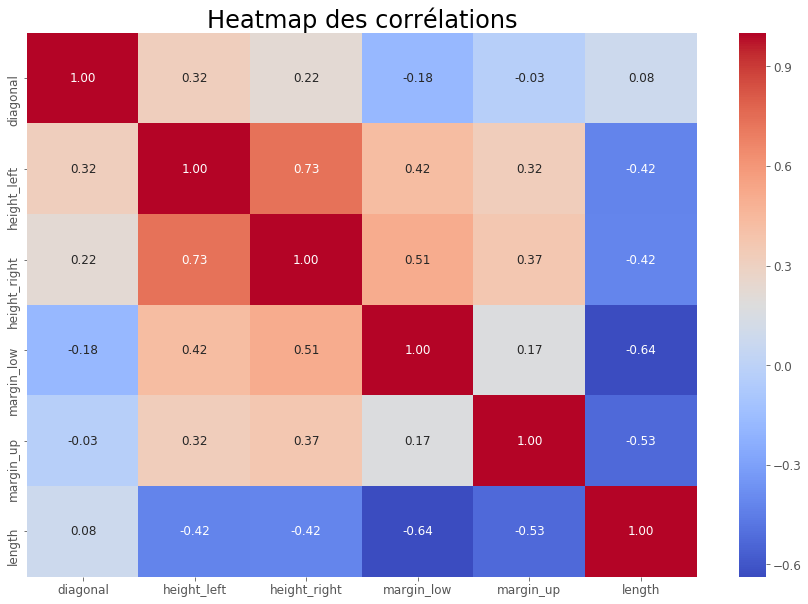

In [16]:
#HeatMap des corrélations linéaires à partir de la matrice précédente
plt.figure(figsize=(15, 10))
sns.heatmap(data.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap des corrélations')

plt.savefig("p6_graphic/heatmap.png")
plt.show()

*Des corrélations linéaires existent entre certaines de nos variables, voyons plus en détails…*

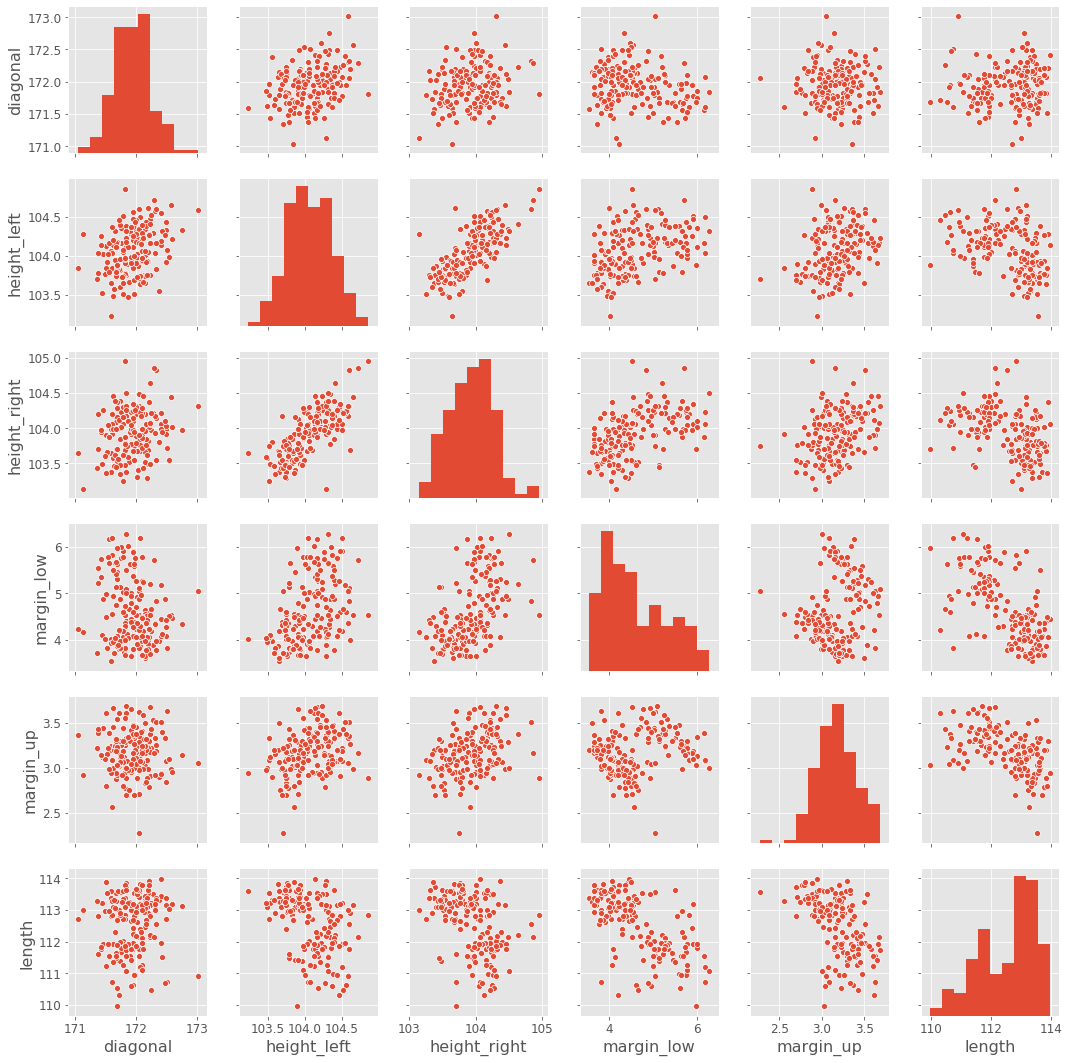

In [17]:
#Visualisation exploratoire des 6 variables quantitatives
#.pairplot une méthode de Seaborn simple et rapide pour se faire une idée visuelle des corrélations ou non
sns.pairplot(data.iloc[:, 1:])

plt.savefig("p6_graphic/pairplot.png")
plt.show()

*Il ressort une corrélation linéaire entre les deux variables 'height_left' et 'height_right', le coefficient de pearson sera calculé pour vérifier l'observation.*

*Même si nous avons déjà les coefficients de Pearson dans le précédent HeatMap, une vérification est pertinente.*

In [18]:
#Coefficient de corrélation linéaire de Pearson entre 'height_left' et 'height_right'
coef_height = st.pearsonr(data['height_right'], data['height_left'])[0]
coef_height

0.7343902682297874

*La valeur obtenue est proche de 1, il existe donc une réelle corrélation linéaire entre ces deux variables. Concrètement, au plus 'height_left' aura une valeur élevée, au plus 'height_right' le sera aussi.*

In [19]:
#Coefficient de corrélation linéaire de Pearson entre 'length' et 'margin_low'
coef_length_margin = st.pearsonr(data['length'], data['margin_low'])[0]
coef_length_margin

-0.6373516884716646

*La valeur obtenue est proche de -1, il existe donc une corrélation linéaire négative entre ces deux variables.*

*La transition vers le prochaines étapes de l'analyse portera sur la <strong>"sélection des variables explicatives à inclure dans le modèle de régression logistique multiple</strong>. Lors de cette démarche, il ne faut pas inclure des variables redondantes (trop liées entre elles). Dans un tel cas, on parle de colinéarité entre ces variables. Ce problème a pour conséquence un modèle de qualité médiocre (impossibilité d’estimation des coefficients). La colinéarité entre les variables doit donc être vérifiée lors de la réalisation d’une régression logistique. Une vérification de la colinéarité sera menée avant de modéliser notre régression logistique.*

*On considère ici que l'on dispose de n observations d'un échantillon i.i.d «variables indépendantes et identiquement distribuées».\
<strong>Nous pourrons ainsi nous placer dans le modèle de Bernoulli, et mettre en oeuvre une Regression Logistique</strong>.* 

[Voir la suite du projet : Analyse en composantes principales de l'échantillon](https://github.com/nalron/project_counterfeit_banknote/blob/french_version/p6_notebook02.ipynb)